In [91]:
%pylab inline
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [92]:
pathMAC="/Users/jfmv/Documents/Proyectos/Moire-Phonon_QMC/BM_bandstructure"
pathchow='/home/jfm343/Documents/Moire_phonon/BM_bandstructure'
path=pathMAC+'/Mods/data20_mode_L_symmetry_a_alpha_0.0_beta_1.0_umklp_0_kappa_0.8174358974358973_theta_0.01832595714594046.h5'
df = pd.read_hdf(path)

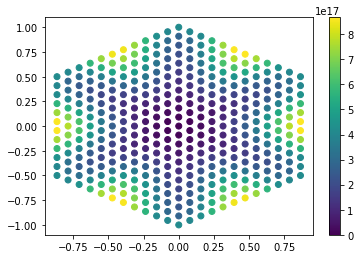

In [93]:
df_prime=df.loc[df['nu']==0]
scatter(df_prime['kx'],df_prime['ky'], c=df_prime['bub'])
colorbar()

Text(0, 0.5, '$\\alpha/ c_L$')

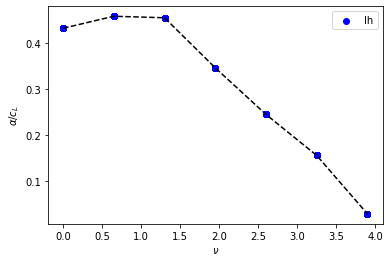

In [94]:

fillings=df['nu']
cep=df['delt_cph']/21400
plt.scatter(fillings, cep, c='b', label='lh')
plt.plot(fillings, cep, c='k', ls='--')
plt.legend()
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\alpha/ c_L$")
# plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


## For the twist angle

In [95]:

path=pathMAC+'/data/thetasweep_kappa_0.75_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
for i, pat in enumerate(subpaths):
    print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)
df=pd.concat(frames).sort_values(['theta', 'nu'])




thetasweep_kappa_0.75_N30_0.96_2022-01-25-23-13-12
thetasweep_kappa_0.75_N30_0.92_2022-01-25-21-44-51
thetasweep_kappa_0.75_N30_1.02_2022-01-25-21-50-38
thetasweep_kappa_0.75_N30_1.14_2022-01-25-21-58-44
thetasweep_kappa_0.75_N30_0.9_2022-01-25-23-37-24
thetasweep_kappa_0.75_N30_1.08_2022-01-25-23-18-26
thetasweep_kappa_0.75_N30_0.98_2022-01-25-21-50-21
thetasweep_kappa_0.75_N30_1.1_2022-01-25-23-08-17
thetasweep_kappa_0.75_N30_0.88_2022-01-25-21-42-14
thetasweep_kappa_0.75_N30_1.12_2022-01-25-21-54-38
thetasweep_kappa_0.75_N30_1.06_2022-01-25-21-52-15
thetasweep_kappa_0.75_N30_0.86_2022-01-25-21-43-51
thetasweep_kappa_0.75_N30_0.94_2022-01-25-22-46-50
thetasweep_kappa_0.75_N30_1.04_2022-01-25-21-53-37
thetasweep_kappa_0.75_N30_1.0_2022-01-25-21-51-51
thetasweep_kappa_0.75_N30_0.84_2022-01-25-22-34-23


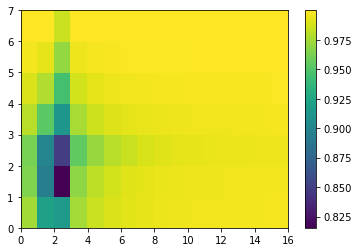

In [96]:

dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)


# dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
# tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
# sh=[np.shape(tablenuthet)[1],np.shape(tablenuthet)[0]]
# xp=np.array(dataframeatgamma['nu'])
# x=np.reshape(xp,sh)
# yp=np.array(dataframeatgamma['theta'])
# y=np.reshape(xp,sh)
# zp=np.array(dataframeatgamma['delt_cph'])
# z=np.reshape(xp,sh)
# cLong=21400
# cep=z/cLong
# effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

# # fig,ax = plt.subplots()
# # c=ax.pcolormesh(x,y,effectivec)
# # fig.colorbar(c, ax=ax)
# imshow(effectivec)


In [97]:

path=pathMAC+'/data/thetasweep_kappa_0.5_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
for i, pat in enumerate(subpaths):
    print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)
df=pd.concat(frames).sort_values(['theta', 'nu'])




thetasweep_kappa_0.5_N30_0.98_2022-01-26-09-57-17
thetasweep_kappa_0.5_N30_0.9_2022-01-26-07-34-22
thetasweep_kappa_0.5_N30_1.0_2022-01-26-08-52-45
thetasweep_kappa_0.5_N30_0.86_2022-01-26-07-18-24
thetasweep_kappa_0.5_N30_1.12_2022-01-26-07-11-47
thetasweep_kappa_0.5_N30_0.96_2022-01-26-10-01-40
thetasweep_kappa_0.5_N30_1.04_2022-01-26-07-20-54
thetasweep_kappa_0.5_N30_1.02_2022-01-26-07-54-54
thetasweep_kappa_0.5_N30_0.88_2022-01-26-06-13-37
thetasweep_kappa_0.5_N30_1.08_2022-01-26-07-30-15
thetasweep_kappa_0.5_N30_1.14_2022-01-26-07-29-04
thetasweep_kappa_0.5_N30_1.1_2022-01-26-07-40-16
thetasweep_kappa_0.5_N30_0.92_2022-01-26-06-21-35
thetasweep_kappa_0.5_N30_0.94_2022-01-26-06-24-40
thetasweep_kappa_0.5_N30_1.06_2022-01-26-06-46-13
thetasweep_kappa_0.5_N30_0.84_2022-01-26-07-37-18


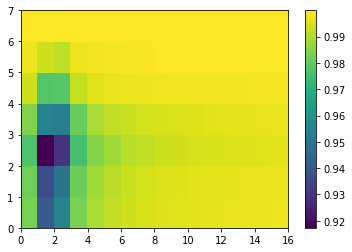

In [98]:

dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)

In [99]:

path=pathMAC+'/data/thetasweep_kappa_0.3_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
for i, pat in enumerate(subpaths):
    print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)
df=pd.concat(frames).sort_values(['theta', 'nu'])




thetasweep_kappa_0.3_N30_0.9_2022-01-26-09-08-18
thetasweep_kappa_0.3_N30_1.12_2022-01-26-06-31-49
thetasweep_kappa_0.3_N30_0.98_2022-01-26-07-24-32
thetasweep_kappa_0.3_N30_0.84_2022-01-26-06-17-12
thetasweep_kappa_0.3_N30_1.08_2022-01-26-06-46-28
thetasweep_kappa_0.3_N30_0.92_2022-01-26-06-57-01
thetasweep_kappa_0.3_N30_1.04_2022-01-26-06-14-24
thetasweep_kappa_0.3_N30_1.1_2022-01-26-07-26-43
thetasweep_kappa_0.3_N30_0.88_2022-01-26-06-40-09
thetasweep_kappa_0.3_N30_1.02_2022-01-26-06-57-25
thetasweep_kappa_0.3_N30_1.06_2022-01-26-07-06-30
thetasweep_kappa_0.3_N30_0.86_2022-01-26-06-14-49
thetasweep_kappa_0.3_N30_0.94_2022-01-26-06-15-41
thetasweep_kappa_0.3_N30_1.0_2022-01-26-06-16-37
thetasweep_kappa_0.3_N30_0.96_2022-01-26-07-09-02
thetasweep_kappa_0.3_N30_1.14_2022-01-26-06-16-49


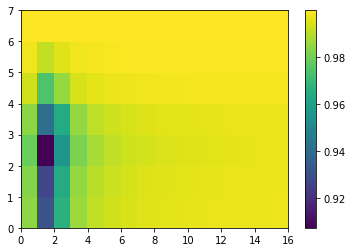

In [100]:

dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)

range of twist angles 0.010499999999999954


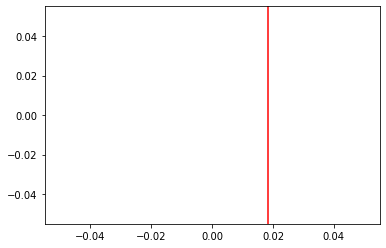

In [101]:
scatter(thet, renorm2)
axvline(1.05*np.pi/180, c='r')
# axvline((1.015)*1.05*np.pi/180, c='k')
# axvline((1.025)*1.05*np.pi/180, c='k')
# axvline((1.02)*1.05*np.pi/180, c='k')
print("range of twist angles", (1.025)*1.05-(1.015)*1.05)
NS=20
# for i in range(NS):
#     l=(i-int(NS/2))*0.005
#     axvline((1+l)*1.05*np.pi/180)
#     print((1+l))

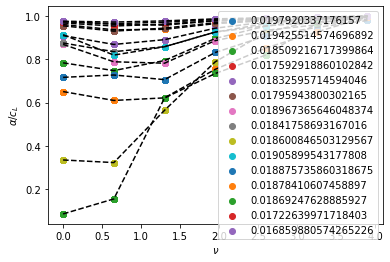

In [102]:
path=pathMAC+'/data/thetasweep_kappa_0.817_beta_4ev_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        

for i, pat in enumerate(subpaths):
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    df = pd.read_hdf(fullpath)
    
    fillings=df['nu']
    cep=df['delt_cph']/21400
    cep2=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)
    plt.scatter(fillings, cep2, label=str(df['theta'][0]))
    plt.plot(fillings, cep2, c='k', ls='--')
    plt.legend()
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\alpha/ c_L$")
    # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


# For kappa

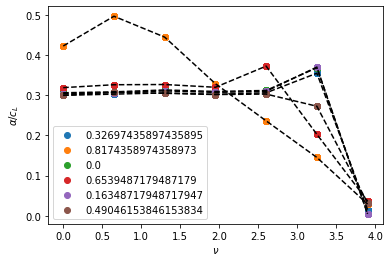

In [10]:
path='/home/jfm343/Documents/Moire_phonon/BM_bandstructure/data/kappasweep_theta_1.05_beta_4ev_N30_2022-01-20-09-58-20'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        

for i, pat in enumerate(subpaths):
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'T')
    fullpath=fulpath+'/'+data[0]
    
    df = pd.read_hdf(fullpath)
    
    fillings=df['nu']
    cep=df['delt_cph']/21400
    cep2=np.sqrt(1-cep**2)
    plt.scatter(fillings, cep, label=str(df['kappa'][0]))
    plt.plot(fillings, cep, c='k', ls='--')
    plt.legend()
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\alpha/ c_L$")
    # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


In [19]:
import Hamiltonian
import MoireLattice
from scipy import linalg as la

#Lattice parameters 
#lattices with different normalizations
modulation_thet=1
Nsamp=10
theta=modulation_thet*1.05*np.pi/180  # magic angle 
l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
[KX,KY]=lq.Generate_lattice()
Npoi=np.size(KX); print(Npoi, "numer of sampling lattice points")
[q1,q2,q3]=l.q
q=la.norm(q1)
umkl=0
print(f"taking {umkl} umklapps")
VV=lq.boundary()

print(q, 2*np.sin(theta/2)*np.pi*(4/3))

starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.005800485610961914  s
91 numer of sampling lattice points
taking 0 umklapps
0.07676251561000431 0.0767625156100043
